In [1]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

### Dataset Download

In [2]:
!gdown --id 1bB_X5edGrrCaYrU_JsU1xKy88hO6XNpv

Downloading...
From: https://drive.google.com/uc?id=1bB_X5edGrrCaYrU_JsU1xKy88hO6XNpv
To: /content/image_recognize_dataset.zip
748MB [00:13, 54.8MB/s]


In [ ]:
!unzip image_recognize_dataset.zip

### Utils and Data laoder

In [4]:
final_paths = []
final_texts = []


path = "image_recognize_dataset"

for i in os.listdir(path):
    for j in os.listdir(path+"/"+str(i)):
        for x in os.listdir(path+"/"+str(i)+"/"+str(j)):
            final_paths.append(path+"/"+str(i)+"/"+str(j)+"/"+x)
            final_texts.append(str(x).split("_")[1])

# data_folder = "mjsynth_sample"
# for path in os.listdir(data_folder):


#     final_paths.append(data_folder + "/" + path)
#     final_texts.append(path.split("_")[1])

In [5]:
final_paths[:10], final_texts[:10]

(['image_recognize_dataset/98/1/96_Shula_70638.jpg',
  'image_recognize_dataset/98/1/174_WHUP_86463.jpg',
  'image_recognize_dataset/98/1/335_AFFORDING_1443.jpg',
  'image_recognize_dataset/98/1/226_DIVOT_22944.jpg',
  'image_recognize_dataset/98/1/341_CLADDAGH_13842.jpg',
  'image_recognize_dataset/98/1/347_CRATERING_17850.jpg',
  'image_recognize_dataset/98/1/279_CIRCE_13704.jpg',
  'image_recognize_dataset/98/1/80_teleology_77977.jpg',
  'image_recognize_dataset/98/1/250_TALLBOY_77329.jpg',
  'image_recognize_dataset/98/1/494_Dissimulator_22689.jpg'],
 ['Shula',
  'WHUP',
  'AFFORDING',
  'DIVOT',
  'CLADDAGH',
  'CRATERING',
  'CIRCE',
  'teleology',
  'TALLBOY',
  'Dissimulator'])

In [6]:
len(final_texts)

449464

In [7]:
vocab = set("".join(map(str, final_texts)))
print(sorted(vocab))

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


In [8]:
Counter("".join(map(str, final_texts)))

Counter({'!': 849,
         '"': 2981,
         '#': 305,
         '$': 1038,
         '%': 289,
         '&': 172,
         "'": 9981,
         '(': 5688,
         ')': 2988,
         '*': 454,
         '+': 216,
         ',': 22725,
         '-': 8199,
         '.': 24157,
         '0': 5053,
         '1': 7248,
         '2': 3987,
         '3': 3020,
         '4': 2416,
         '5': 2871,
         '6': 1848,
         '7': 1765,
         '8': 1815,
         '9': 2079,
         ':': 56533,
         ';': 520,
         '<': 131,
         '=': 97,
         '>': 13419,
         '?': 1907,
         '@': 172,
         'A': 72248,
         'B': 24565,
         'C': 44479,
         'D': 48788,
         'E': 97769,
         'F': 29016,
         'G': 28782,
         'H': 25260,
         'I': 83367,
         'J': 3969,
         'K': 10527,
         'L': 58032,
         'M': 34015,
         'N': 62980,
         'O': 53983,
         'P': 32358,
         'Q': 2169,
         'R': 73952,
         'S

In [9]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst


In [10]:
encode_to_labels("hello")

[69, 66, 73, 73, 76]

In [11]:
train_final_paths = final_paths[ : int(len(final_paths) * 0.90)]
train_final_texts = final_texts[ : int(len(final_texts) * 0.90)]

val_final_paths = final_paths[int(len(final_paths) * 0.90) : ]
val_final_texts = final_texts[int(len(final_texts) * 0.90) : ]

In [12]:
len(train_final_paths), len(val_final_paths)

(404517, 44947)

In [13]:
max_label_len = max([len(str(text)) for text in final_texts])

In [14]:
max_label_len

23

In [15]:
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):
            
            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)   

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:
                pass

        return [np.array(images), 
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
               np.array(train_input_length), 
               np.array(train_label_length)], np.zeros(len(images))

In [16]:
train_final_paths[:1], train_final_texts[:1]

(['image_recognize_dataset/98/1/96_Shula_70638.jpg'], ['Shula'])

In [17]:
batch_size = 64
train_generator = My_Generator(train_final_paths, train_final_texts, batch_size)
val_generator = My_Generator(val_final_paths, val_final_texts, batch_size)

### CRNN Model

In [18]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

### Loss and Optimizer

In [20]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 128, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 64, 32)   4640        max_pooling2d[0][0]              
____________________________________________________________________________________________

In [22]:
file_path = "C_LSTM_best.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')


checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

### Train

In [23]:
epochs = 10

history = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/10
6320/6320 [==============================] - 435s 63ms/step - loss: 20.3613 - val_loss: 7.7277

Epoch 00001: val_loss improved from inf to 7.72769, saving model to C_LSTM_best.hdf5
Epoch 2/10
6320/6320 [==============================] - 381s 60ms/step - loss: 5.0992 - val_loss: 5.6668

Epoch 00002: val_loss improved from 7.72769 to 5.66682, saving model to C_LSTM_best.hdf5
Epoch 3/10
6320/6320 [==============================] - 369s 58ms/step - loss: 4.0996 - val_loss: 5.3408

Epoch 00003: val_loss improved from 5.66682 to 5.34082, saving model to C_LSTM_best.hdf5
Epoch 4/10
6320/6320 [==============================] - 369s 58ms/step - loss: 3.6531 - val_loss: 5.5958

Epoch 00004: val_loss did not improve from 5.34082
Epoch 5/10
6320/6320 [==============================] - 373s 59ms/step - loss: 3.3943 - val_loss: 5.5459

Epoch 00005: val_loss did not improve from 5.34082
Epoch 6/10
6320/6320 [==============================] - 375s 59ms/step - loss: 3.1753 - val_loss: 5.1950

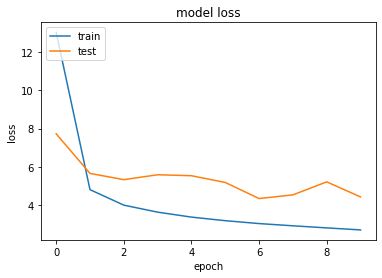

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evalution

In [25]:
def pre_process_image(path):
    
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))

    
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.
    
    return img

In [26]:
act_model.load_weights('C_LSTM_best.hdf5')

In [27]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text    
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print('\n')

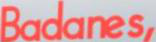



predicted text = Badanes,





predicted text = Despoliation





predicted text = >Later,





predicted text = Newsgroups:





predicted text = Secretariats





predicted text = hygrometers





predicted text = ineffectually





predicted text = LAMEBRAIN





predicted text = WOODCUTTER





predicted text = reason:



In [28]:
from IPython.display import display
from random import randrange

for i in range(10):
    index = randrange(len(val_final_paths))
    im = Image.open(val_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_final_paths[index])
    predict_output(test_img)